# Image similarity search on Azure Cosmos DB for PostgreSQL using the pgvector extension

In this notebook, we will build a basic image similarity search application using the Azure AI Vision multi-modal embeddings APIs and Azure Cosmos DB for PostgreSQL.

In Azure Cosmos DB for PostgreSQL, vector similarity search is enabled by the `pgvector` extension.

Before you start:

1. Create an Azure Cosmos DB for PostgreSQL cluster and enable the `pgvector` extension.
2. Create an Azure Blob Storage container to store the images.
3. Run the `data_preprocessing.ipynb` notebook to clean up the SemArt Dataset and the `generate_embeddings.py` script to compute the embeddings of all the images. The embeddings are saved in the `dataset_embeddings.csv` file in the *dataset* folder.
4. Run the `upload_images_to_blob.py` script to upload the images in your Blob Storage container.
5. Run the `upload_data_to_postgresql.py` script to create a PostgreSQL table and populate it with data.

## Import libraries

In [1]:
import os
import math
import psycopg2
from psycopg2 import pool
from dotenv import load_dotenv
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import sys
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import ConnectionType
from azure.identity import DefaultAzureCredential

# Add parent directory to path to import from modules folder
# Get the notebook directory and add parent to path
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from modules import constants as c
from modules import utils

## Load environment variables

In [2]:
project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.environ["PROJECT_ENDPOINT"],
    logging_enable=True
)

In [3]:
load_dotenv("../.env")

# Azure Cosmos DB for PostgreSQL
postgres_host = os.getenv("POSTGRES_HOST")
postgres_database_name = os.getenv("POSTGRES_DB_NAME")
postgres_user = os.getenv("POSTGRES_USER")
postgres_password = os.getenv("POSTGRES_PASSWORD")
sslmode = "require"
table_name = os.getenv("POSTGRES_TABLE_NAME")

# Azure AI Vision
connection = project_client.connections.get(
    name="aivision",
    include_credentials=True
)

# Get the connection properties
vision_endpoint = connection.get("target")
vision_key = connection.credentials.get("key")

vision_endpoint = vision_endpoint + "computervision/"
vision_api_version = os.getenv("VISION_VERSION")


## Connect to Azure Cosmos DB for PostgreSQL

The following code forms a connection string using the environment variables for your Azure Cosmos DB for PostgreSQL cluster and creates a connection pool to your Postgres database. After that, a `cursor` object is created, which can be used to execute SQL queries with the `execute()` method.

In [4]:
# Build a connection string from the variables
postgres_connection_string = (
    f"host={postgres_host} user={postgres_user} dbname={postgres_database_name} "
    f"password={postgres_password} sslmode={sslmode}"
)

In [5]:
postgresql_pool = psycopg2.pool.SimpleConnectionPool(1, 20, postgres_connection_string)
if postgresql_pool:
    print("Connection pool created successfully")

Connection pool created successfully


In [6]:
# Get a connection from the connection pool
conn = postgresql_pool.getconn()
cursor = conn.cursor()

### Select the first 10 rows of the table to see the data

In [10]:
cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
number_of_records = cursor.fetchone()[0]
print(f"Number of records in the table: {number_of_records}")

Number of records in the table: 11206


In [11]:
cursor.execute(f"SELECT * FROM {table_name} LIMIT 10;")
rows = cursor.fetchall()

df_rows = pd.DataFrame(rows, columns=c.COLUMN_NAMES_LIST)
df_rows.head(10)

,image_file,description,author,title,technique,type,timeframe,vector
0,19873-1darmst.jpg,"The Meyer or Darmstadt Madonna is the last, mo...","HOLBEIN, Hans the Younger",Darmstadt Madonna,Oil on limewood,religious,1501-1550,"[0.38500977,2.4785156,-0.09863281,-1.3701172,-..."
1,18759-guard301.jpg,Whereas Canaletto incorporates classically ins...,"GUARDI, Francesco",Landscape with a Fisherman's Tent,Oil on canvas,landscape,1751-1800,"[-1.6982422,-0.34643555,-3.5566406,1.7519531,-..."
2,00930-30coron.jpg,Fra Angelico dedicated several of his works to...,"ANGELICO, Fra",The Coronation of the Virgin,Tempera on wood,religious,1401-1450,"[-0.5678711,0.5083008,1.0371094,0.29125977,0.0..."
3,18424-2105grec.jpg,This portrait is an example of El Greco's late...,"GRECO, El",Portrait of Cardinal Tavera,Oil on canvas,portrait,1551-1600,"[-1.7607422,-0.18823242,-0.85498047,2.8769531,..."
4,21949-4lastsu3.jpg,Leonardo's painting of the Last Supper was con...,LEONARDO da Vinci,The Last Supper,Mixed technique,religious,1451-1500,"[-1.8486328,-0.113586426,-0.9165039,0.6176758,..."
5,39738-04organ.jpg,This is another original version of the Venus ...,TIZIANO Vecellio,Venus and Cupid with an Organist,Oil on canvas,mythological,1501-1550,"[-0.8408203,-0.07684326,0.1227417,0.035980225,..."
6,29467-canal_mo.jpg,Aert Van der Neer painted his first moonlit la...,"NEER, Aert van der",A Canal by Moonlight,Oil on oak panel,landscape,1601-1650,"[-1.7255859,-0.75097656,-2.6757812,1.0996094,-..."
7,12035-painstud.jpg,It is assumed that the painter represented in ...,"DOU, Gerrit",Painter in his Studio,Oil on oak,genre,1651-1700,"[-2.7558594,0.8930664,-2.8808594,2.2011719,0.6..."
8,36091-4absalo1.jpg,The large scene on the long wall opposite to t...,"SALVIATI, Cecchino del",The Story of David (4 scenes),Fresco,religious,1501-1550,"[-1.2412109,0.02230835,-0.89941406,1.2441406,1..."
9,20109-44hooch.jpg,Pieter de Hooch depicts for us incidents in th...,"HOOCH, Pieter de",Woman Reading a Letter,Oil on canvas,genre,1651-1700,"[-1.0351562,-0.1239624,-0.2836914,0.9277344,1...."


## Search images using an image or a text prompt

After populating the table with vector data, you can use this image collection to search for images that are most similar to a reference image or a text prompt. The workflow is summarized as follows:

1. Use the Vectorize Image API or the Vectorize Text API to generate vector embeddings of an image or text, respectively.
2. To calculate similarity and retrieve images, use `SELECT` statements and the built-it vector operators of the PostgreSQL database.
3. Display the retrieved images using the `display_image_grid()` function.


In [7]:
TOP_N = 3

### Text-to-Image Search

#### Calculate the vector embedding of the text prompt

Let's search for paintings depicting "a table with flowers."

In [8]:
text_prompt = "a table with flowers"
query_vector = utils.vectorize_text(
    text=text_prompt,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

In [ ]:
query_vector

#### Query the table to find the most similar images

In [9]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} ORDER BY {c.VECTOR_COLUMN_NAME} <=> %s LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME]
)
df_rows.head(TOP_N)

,image_file,author,title
0,08537-2still2.jpg,"CEZANNE, Paul",Still-Life with Flowers and Fruit
1,14909-early11.jpg,"GAUGUIN, Paul",Still-Life with Mandoline
2,14903-early05.jpg,"GAUGUIN, Paul","Interior of the Artist's Home, Rue Carcel"


Display the retrieved images.

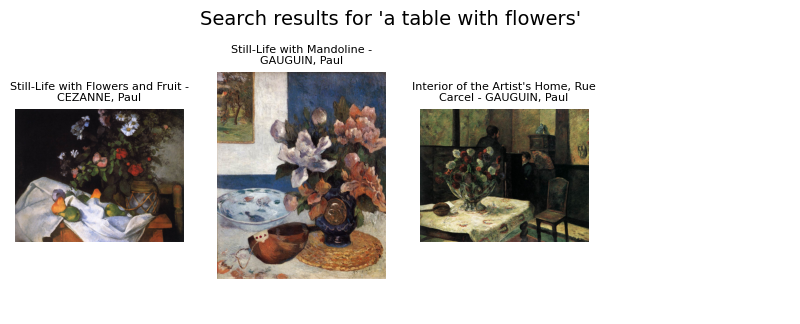

In [10]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
)


As evident, all the paintings showcase a table with flowers. Through vector search, we successfully retrieved images similar to a text prompt by relying solely on the visual information present in the images, without utilizing metadata.

#### Query the table to find the cosine similarity

Let's modify the `SELECT` SQL query to retrieve the cosine similarity between the text prompt and the retrieved images.

In [16]:
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, 1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(rows, columns=[c.IMAGE_FILE_COLUMN_NAME, "cosine_similarity"])
df_rows.head(TOP_N)

,image_file,cosine_similarity
0,08537-2still2.jpg,0.376424
1,14909-early11.jpg,0.374863
2,14903-early05.jpg,0.374332


Display the retrieved images.

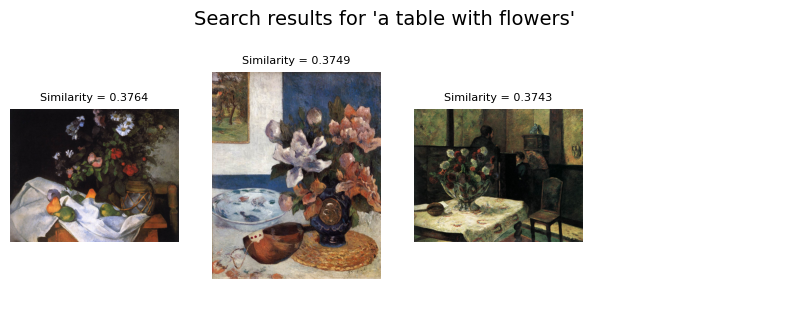

In [17]:
image_names = [row[0] for row in rows]
image_titles = [
    f"Similarity = {round(row[1], 4)}" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
)


#### Metadata filtering

Filtering is an essential component of search systems, enabling users to narrow down search results, such as searching for paintings by Vincent van Gogh that depict a table with flowers. However, implementing accurate and fast metadata filtering in vector search systems is a challenging task. You can read the article [The Missing WHERE Clause in Vector Search](https://www.pinecone.io/learn/vector-search-filtering/) on the Pinecone blog to learn about the two fundamental approaches for metadata filtering and understand the complexities involved in implementing such filters into vector search applications.

In the following example, we will explore a basic approach for applying a filter using the SQL `WHERE` clause. Initially, we will filter based on the name of the artist to retrieve all paintings by Vincent van Gogh. Subsequently, we will conduct an exact nearest neighbor search to retrieve paintings that depict "a table with flowers."

You can find more information about filtering with the `pgvector` extension on the  [pgvector GitHub repository](https://github.com/pgvector/pgvector?tab=readme-ov-file#filtering).

In [18]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} "
    f"WHERE {c.AUTHOR_COLUMN_NAME} = 'GOGH, Vincent van' "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

,image_file,author,title,cosine_similarity
0,17114-3arles28.jpg,"GOGH, Vincent van",Still-Life with Oleanders and Books,0.372184
1,17071-paris21.jpg,"GOGH, Vincent van",Interior of a Restaurant,0.368253
2,17036-flower09.jpg,"GOGH, Vincent van",Still-Life,0.363841


Display the retrieved images.

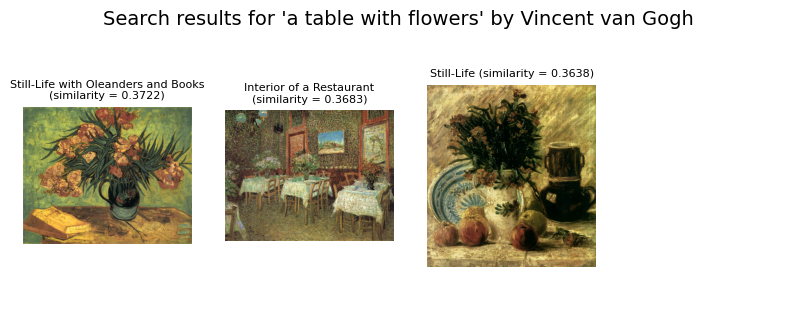

In [19]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}' by Vincent van Gogh",
    nrows=nrows,
    ncols=ncols,
)


#### Retrieve paintings by Vincent van Gogh without applying any filters

In the previous example, we filtered the table by the name of the artist and then applied nearest neighbor search to find paintings depicting "a table with flowers." In this example, we will explore whether it's possible to retrieve paintings of a specific artist without applying filters by including their name in the text prompt.

In [20]:
text_prompt = "flowers by Vincent van Gogh"
query_vector = utils.vectorize_text(
    text=text_prompt,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)

In [21]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

,image_file,author,title,cosine_similarity
0,17114-3arles28.jpg,"GOGH, Vincent van",Still-Life with Oleanders and Books,0.407561
1,17031-flower04.jpg,"GOGH, Vincent van",Vase with Zinnias and Other Flowers,0.401167
2,17035-flower08.jpg,"GOGH, Vincent van",Fritillaries in a Copper Vase,0.399391


Display the retrieved images.

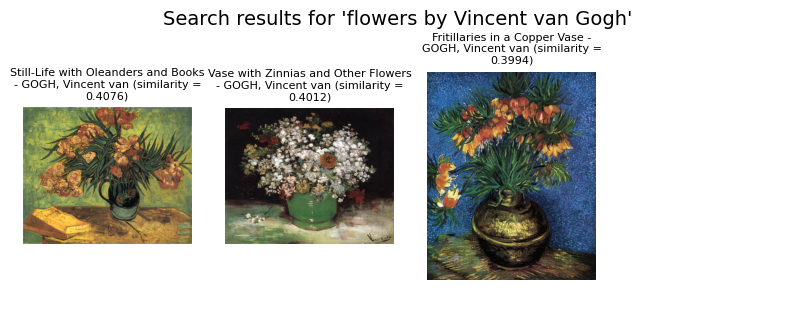

In [22]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title=f"Search results for '{text_prompt}'",
    nrows=nrows,
    ncols=ncols,
)


We observe that we retrieve paintings depicting flowers by Vincent Van Gogh without filtering the table by the name of the artist.

Feel free to experiment with alternative text prompts and review the results. It's important to note that including the name of a specific artist in the text prompt **doesn't** guarantee that only paintings by that artist will be returned.

### Image-to-Image Search

#### Calculate the vector embeddings of the reference image

In the text-to-image search examples, we observed that we can retrieve images similar to the text prompt "a table with flowers" by calculating the cosine similarity between the vector of the paintings and the query. Let's explore if we can obtain paintings depicting a table with flowers, using another painting as a reference this time.

We will use the painting [*Still Life with Flowers* by Charles Ginner](https://artuk.org/discover/artworks/still-life-with-flowers-8115/search/actor:ginner-charles-18781952/page/1/view_as/grid).

In [12]:
reference_image = "../dataset/reference_image.jpg"
query_vector = utils.vectorize_image_with_filepath(
    image_filepath=reference_image,
    endpoint=vision_endpoint,
    key=vision_key,
    version=vision_api_version,
)


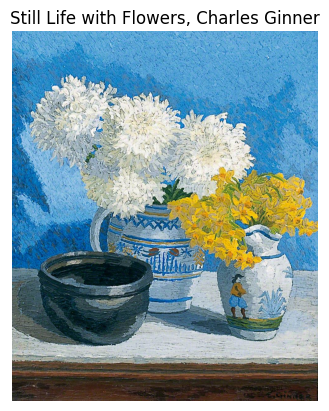

In [13]:
# Display the reference image
plt.imshow(Image.open(reference_image))
plt.axis("off")
plt.title("Still Life with Flowers, Charles Ginner")
plt.show()

#### Query the table to find the most similar images

In [14]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> %s) AS cosine_similarity "
    f"FROM {table_name} ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (str(query_vector),),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

,image_file,author,title,cosine_similarity
0,08520-3still1.jpg,"CEZANNE, Paul",Bouquet of Flowers in a Blue Vase,0.874014
1,14909-early11.jpg,"GAUGUIN, Paul",Still-Life with Mandoline,0.867413
2,17036-flower09.jpg,"GOGH, Vincent van",Still-Life,0.866643


Display the retrieved images.

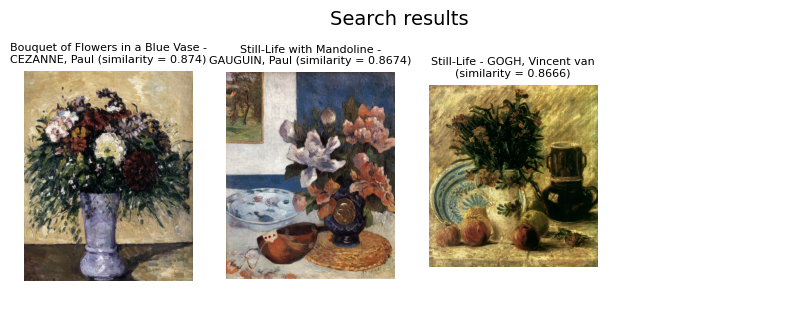

In [15]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
)


#### Find the most similar images to an image of the dataset

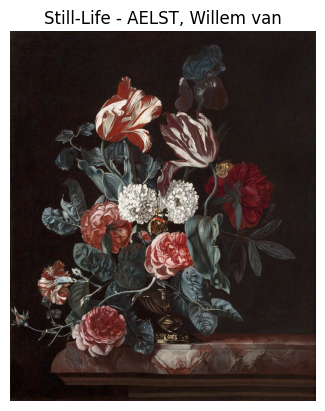

In [16]:
image_file = "00100-stillif.jpg"

# Load the image from local directory
images_dir = os.path.join(parent_dir, 'semart_dataset', 'Images')
image_path = os.path.join(images_dir, image_file)

# Retrieve image metadata
cursor.execute(
    f"SELECT {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s;",
    (image_file,),
)
metadata = cursor.fetchone()

# Display the reference image
plt.imshow(Image.open(image_path))
plt.axis("off")
plt.title(f"{metadata[1]} - {metadata[0]}")
plt.show()


In [17]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s)) "
    f"AS cosine_similarity "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (image_file, image_file),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

,image_file,author,title,cosine_similarity
0,19473-vase_flo.jpg,"HEEM, Jan Davidsz. de",Vase of Flowers,0.964499
1,00107-vasewatc.jpg,"AELST, Willem van",Vase of Flowers with Pocket Watch,0.958481
2,00095-stilflow.jpg,"AELST, Willem van",Still-Life,0.954342


Display the retrieved images.

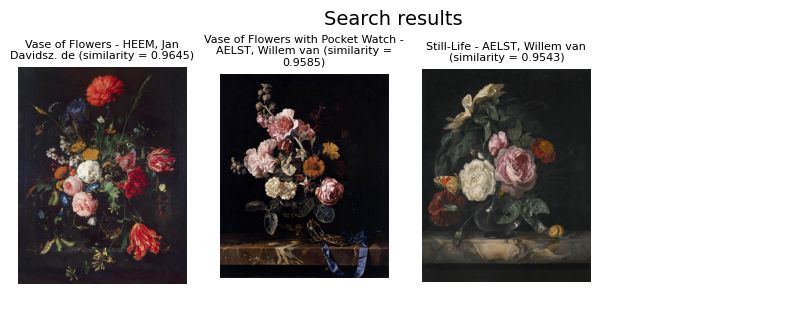

In [18]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
)


We notice that the images are not only semantically similar, depicting a table with flowers, but they also share similarities in their colors.

Let's explore one more example. This time, we will use the painting "Gauguin's Chair" by Vincent van Gogh as a reference.

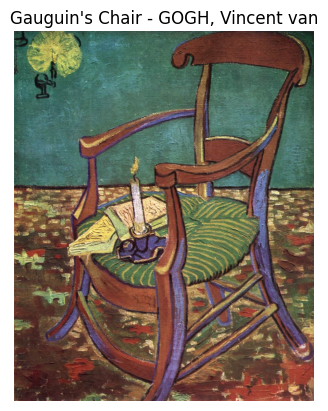

In [19]:
painting_title = "Gauguin's Chair"
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME} "
    f"FROM {table_name} "
    f"WHERE {c.TITLE_COLUMN_NAME} = %s;",
    (painting_title,),
)
painting_info = cursor.fetchone()

# Load the image from local directory
images_dir = os.path.join(parent_dir, 'semart_dataset', 'Images')
image_path = os.path.join(images_dir, painting_info[0])

# Display the reference image
plt.imshow(Image.open(image_path))
plt.axis("off")
plt.title(f"{painting_title} - {painting_info[1]}")
plt.show()


In [20]:
# Vector search
cursor.execute(
    f"SELECT {c.IMAGE_FILE_COLUMN_NAME}, {c.AUTHOR_COLUMN_NAME}, {c.TITLE_COLUMN_NAME}, "
    f"1 - ({c.VECTOR_COLUMN_NAME} <=> (SELECT {c.VECTOR_COLUMN_NAME} FROM {table_name} WHERE {c.IMAGE_FILE_COLUMN_NAME} = %s)) "
    f"AS cosine_similarity "
    f"FROM {table_name} "
    f"WHERE {c.IMAGE_FILE_COLUMN_NAME} != %s "
    f"ORDER BY cosine_similarity DESC "
    f"LIMIT {TOP_N};",
    (painting_info[0], painting_info[0]),
)

# Retrieve the results
rows = cursor.fetchall()
df_rows = pd.DataFrame(
    rows,
    columns=[c.IMAGE_FILE_COLUMN_NAME, c.AUTHOR_COLUMN_NAME, c.TITLE_COLUMN_NAME, "cosine_similarity"]
)
df_rows.head(TOP_N)

,image_file,author,title,cosine_similarity
0,17137-arles59.jpg,"GOGH, Vincent van",Vincent's Chair with His Pipe,0.903429
1,17126-arles48.jpg,"GOGH, Vincent van",Vincent's Bedroom in Arles,0.866792
2,17230-4earlie1.jpg,"GOGH, Vincent van",Vincent's Bedroom in Arles,0.866695


Display the retrieved images.

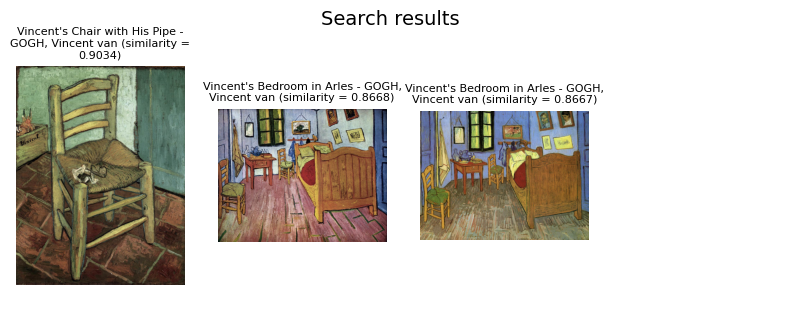

In [21]:
image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
)


image_names = [row[0] for row in rows]
image_titles = [
    f"{row[2]} - {row[1]} (similarity = {round(row[3], 4)})" for row in rows
]
ncols = 4
nrows = math.ceil(len(image_names) / ncols)
utils.display_image_grid(
    image_names=image_names,
    image_titles=image_titles,
    figure_title="Search results",
    nrows=nrows,
    ncols=ncols,
)


## Close the connection

In [22]:
conn.commit()
cursor.close()
conn.close()